# Naïve Bayes algorithm for classification

In [397]:
import pickle
import json
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing 
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler

#os.chdir('/Users/bwilliams/GoogleDrive/UniversityOfHelsinki/Fall2020/IML/TeamProject/TermProjectIML/bin')
os.chdir('C:/Users/saukk/Desktop/ML_Project/bin')
from SplitData import *

### Define help function

In [398]:
def print_nbr_classes(name, df):
    set_size=len(df)
    print(name, "set")
    print("nonevent:", len(df[df["class4"]=="nonevent"]), "pcs", round(len(df[df["class4"]=="nonevent"])/set_size, 3), "%")
    print("II:", len(df[df["class4"]=="II"]), "pcs", round(len(df[df["class4"]=="II"])/set_size, 3), "%")
    print("Ib:", len(df[df["class4"]=="Ib"]), "pcs", round(len(df[df["class4"]=="Ib"])/set_size, 3), "%")
    print("Ia:", len(df[df["class4"]=="Ia"]), "pcs", round(len(df[df["class4"]=="Ia"])/set_size, 3), "%")
    print("Total:", set_size, "pcs")
    print("")

def data_cleaner(df):
    data = df.copy()
    
    #remove the id, partlybad columns
    data.drop(["id","partlybad", "date"],1,inplace=True)
    
    #set new index using the date column
    #data.set_index(["date"],inplace=True)
    
    #add binary 'class2' col for event/non-event
    data["class2"] = np.where(data["class4"] == "nonevent", "nonevent","event")
    
    #arrange to put class2 col at the front
    cols = ['class2'] + [col for col in data if col != 'class2']
    
    # Return cleaned and re-arranged dataframe
    return data[cols]


def normalize_0to1(df):
    # create a scaler object
    scaler = MinMaxScaler()
    # fit and transform the data
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    # Return result
    return df_norm

def find_n_best_feature(X, y, n):
    # Normalize X values to be between 0 and 1
    #x = X.values
    #min_max_scaler = preprocessing.MinMaxScaler()
    #x_scaled = min_max_scaler.fit_transform(x)
    #X = pd.DataFrame(x_scaled)

    # Use SelectKBest class to extract top n best features
    bestfeatures = SelectKBest(score_func=chi2, k=n)
    fit = bestfeatures.fit(X_train_norm, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X_train_norm.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['col_name','Score']
    featureScores= featureScores.nlargest(n,'Score')
    cols = list(featureScores["col_name"])
    return cols

### Import data and print length and categorical distribution

In [399]:
X_train = X_train
X_train_norm = normalize_0to1(X_train)
y_train = y_train
y_train_bin = convert_binary(y_train)
print("Train set")
print("Len:",len(y_train))
print(y_train.value_counts(normalize=True),"\n")

X_test = X_test
X_test_norm = normalize_0to1(X_test)
y_test = y_test
y_test_bin = convert_binary(y_test)
print("Test set")
print("Len:",len(y_test))
print(y_test.value_counts(normalize=True),"\n")

X_val = X_val
X_val_norm = normalize_0to1(X_val)
y_val = y_val
y_val_bin = convert_binary(y_val)
print("Validation set")
print("Len:",len(y_val))
print(y_val.value_counts(normalize=True),"\n")

X_trainval = X_trainval
X_trainval_norm = normalize_0to1(X_trainval)
y_trainval = y_trainval
y_trainval_bin = convert_binary(y_trainval)
print("Trainvalidation set")
print("Len:",len(y_trainval))
print(y_trainval.value_counts(normalize=True),"\n")


os.chdir('C:/Users/saukk/Desktop/ML_Project')
npf_train = pd.read_csv("data/npf_train.csv")
npf_train = data_cleaner(npf_train)
print_nbr_classes("npf_train", npf_train)

Train set
Len: 154
nonevent    0.493506
II          0.220779
Ib          0.214286
Ia          0.071429
Name: class4, dtype: float64 

Test set
Len: 52
nonevent    0.500000
II          0.211538
Ib          0.211538
Ia          0.076923
Name: class4, dtype: float64 

Validation set
Len: 52
nonevent    0.500000
II          0.211538
Ib          0.211538
Ia          0.076923
Name: class4, dtype: float64 

Trainvalidation set
Len: 206
nonevent    0.495146
II          0.218447
Ib          0.213592
Ia          0.072816
Name: class4, dtype: float64 

npf_train set
nonevent: 215 pcs 0.5 %
II: 106 pcs 0.247 %
Ib: 83 pcs 0.193 %
Ia: 26 pcs 0.06 %
Total: 430 pcs



### Make correlation matrix

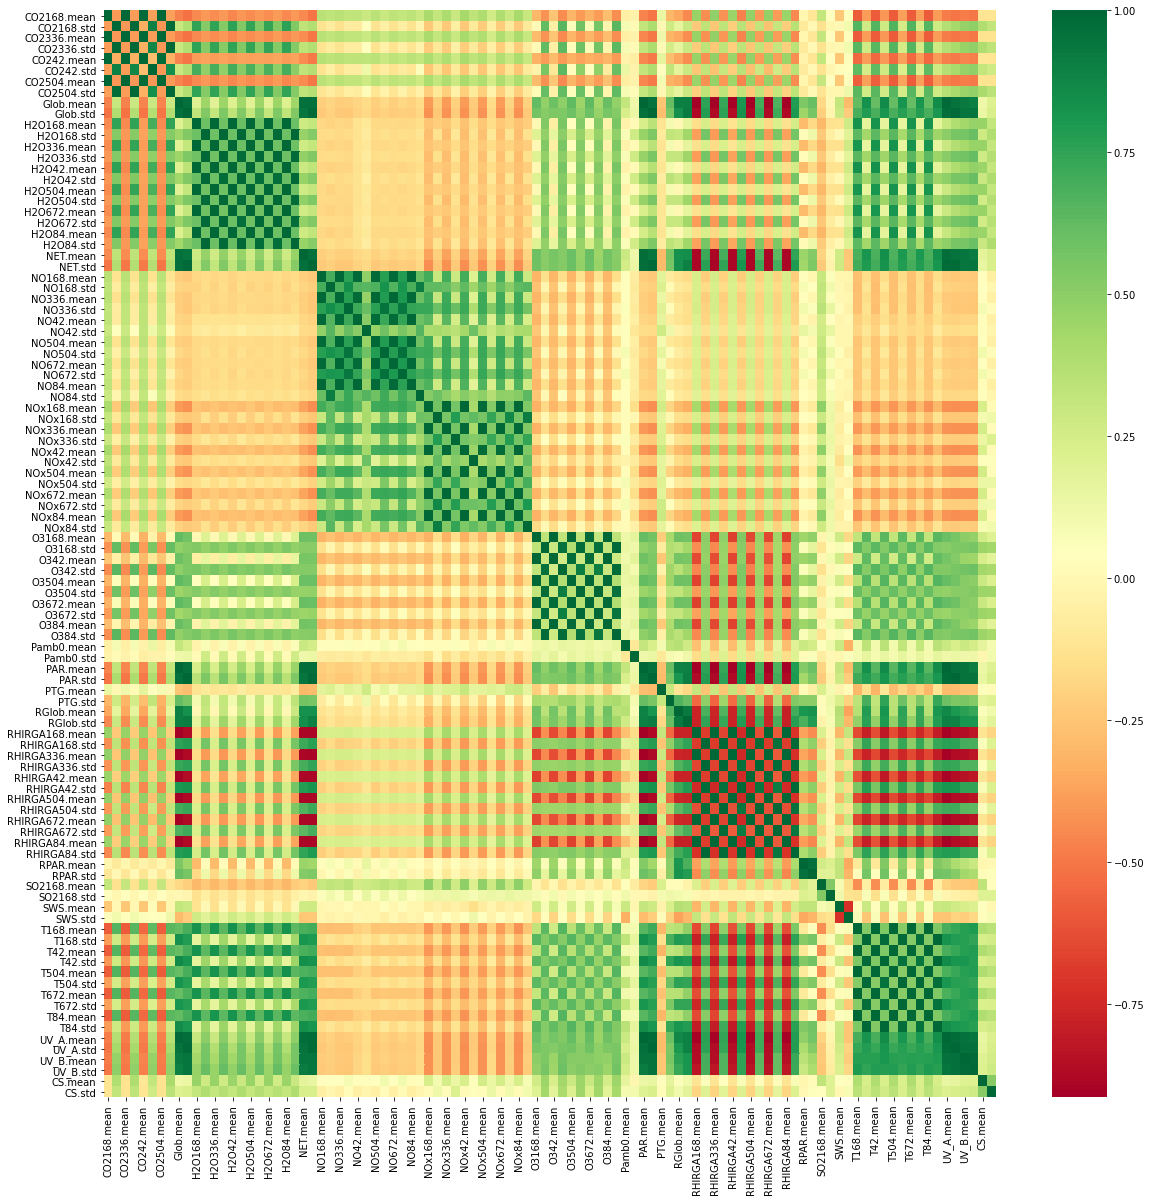

In [400]:
corrmat = npf_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(npf_train[top_corr_features].corr(),annot=False,cmap="RdYlGn")
plt.savefig('train_correlationmatrix.pdf')  

## Test Naive Bayes accuracy

### Gaussian Naive Bayes Binary classification (class2)

In [401]:
model = GaussianNB()
model.fit(X_train, y_train_bin)

print("Gaussian Naive Bayes binary classification")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val)), 2))

Gaussian Naive Bayes binary classification
Train set accurancy: 0.78
Test set accurancy: 0.81
Validation set accurancy: 0.79


### Gaussian Naive Bayes Binary classification (class2) normalized features

In [402]:
model = GaussianNB()
model.fit(X_train_norm, y_train_bin)

print("Gaussian Naive Bayes binary classification normalized features")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train_norm)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test_norm)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val_norm)), 2))

Gaussian Naive Bayes binary classification normalized features
Train set accurancy: 0.78
Test set accurancy: 0.69
Validation set accurancy: 0.81


### Bernoulli Naive Bayes Binary classification (class2)

In [403]:
model = BernoulliNB()
model.fit(X_train, y_train_bin)

print("Bernoulli Naive Bayes binary classification")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val)), 2))

Bernoulli Naive Bayes binary classification
Train set accurancy: 0.64
Test set accurancy: 0.52
Validation set accurancy: 0.63


### Bernoulli Naive Bayes Binary classification (class2) normalized features

In [404]:
model = BernoulliNB()
model.fit(X_train_norm, y_train_bin)

print("Bernoulli Naive Bayes binary classification normalized features")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train_norm)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test_norm)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val_norm)), 2))

Bernoulli Naive Bayes binary classification normalized features
Train set accurancy: 0.66
Test set accurancy: 0.56
Validation set accurancy: 0.65


### Gaussian Naive Bayes Multiclass classification (class4)

In [405]:
model = GaussianNB()
model.fit(X_train, y_train)

print("Gaussian Naive Bayes Multiclass classification")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val)), 2))

Gaussian Naive Bayes Multiclass classification
Train set accurancy: 0.54
Test set accurancy: 0.46
Validation set accurancy: 0.37


### Gaussian Naive Bayes Multiclass classification (class4) normalized features

In [406]:
model = GaussianNB()
model.fit(X_train_norm, y_train)

print("Gaussian Naive Bayes Multiclass classification normalized features")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train_norm)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test_norm)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val_norm)), 2))

Gaussian Naive Bayes Multiclass classification normalized features
Train set accurancy: 0.54
Test set accurancy: 0.52
Validation set accurancy: 0.42


### Bernoulli Naive Bayes Multiclass classification (class4)

In [407]:
model = BernoulliNB()
model.fit(X_train, y_train)

print("Bernoulli Naive Bayes Multiclass classification")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val)), 2))

Bernoulli Naive Bayes Multiclass classification
Train set accurancy: 0.49
Test set accurancy: 0.46
Validation set accurancy: 0.46


### Bernoulli Naive Bayes Multiclass classification (class4) normalized features

In [408]:
model = BernoulliNB()
model.fit(X_train_norm, y_train)

print("Bernoulli Naive Bayes Multiclass classification normalized features")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train_norm)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test_norm)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val_norm)), 2))

Bernoulli Naive Bayes Multiclass classification normalized features
Train set accurancy: 0.51
Test set accurancy: 0.42
Validation set accurancy: 0.35


## Gaussian Naive Bayes Binary accuracy for n number of kBest features

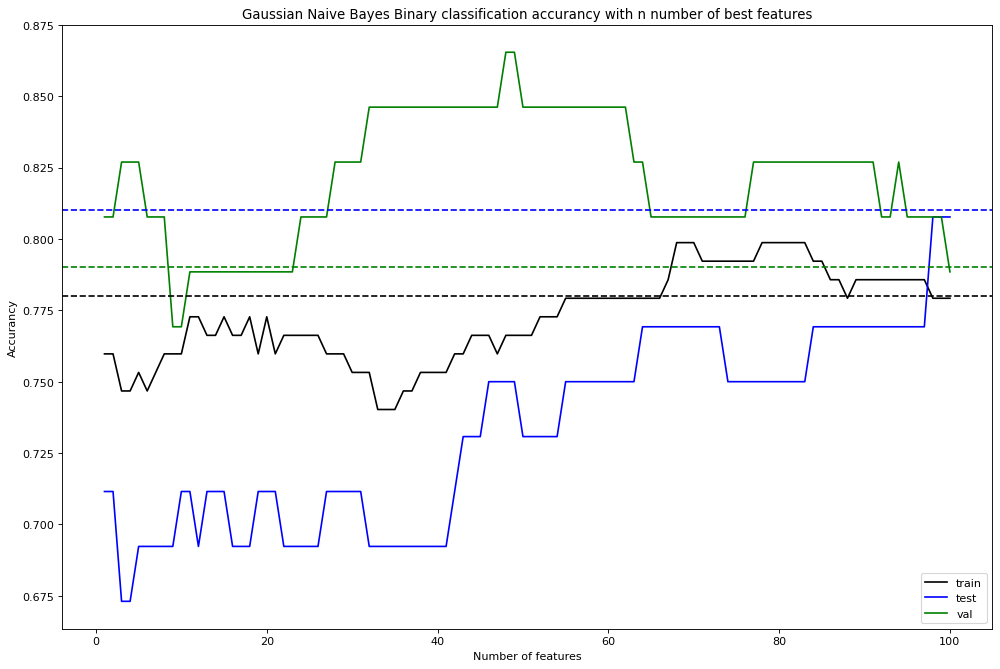

In [409]:
# Define X and y for full dataset
X_npf = npf_train.iloc[:,2:]
y_npf_bin = npf_train["class2"]
X_npf = normalize_0to1(X_npf)

len_cols = len(X_train_norm.columns)+1

acc_train = []
acc_test = []
acc_val = []

for i in range(1, len_cols):
    
    # Train filter with full dataset. Find i number of best col names.
    bestFeatureCols = find_n_best_feature(X_npf, y_npf_bin, i)
    
    # Filter train, val and test set with bestFeaturesFilter
    X_train_i = X_train[bestFeatureCols]
    X_val_i = X_val[bestFeatureCols]
    X_test_i = X_test[bestFeatureCols]
    
    #X_val_i = bestFeaturesFilter.fit_transform(X_val_norm, y_val)
    #X_test_i = bestFeaturesFilter.fit_transform(X_test_norm, y_test)
    
    
    # Train Gaussian Naive Bayes model
    model = GaussianNB()
    model.fit(X_train_i, y_train_bin)
    
    # Save accurancy to list
    acc_train.append(accuracy_score(y_train_bin, model.predict(X_train_i)))
    acc_test.append(accuracy_score(y_test_bin, model.predict(X_test_i)))
    acc_val.append(accuracy_score(y_val_bin, model.predict(X_val_i)))

# Plot the results
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
x = range(1, len_cols)
plt.plot(x, acc_train, color="black")
plt.plot(x, acc_test, color="blue")
plt.plot(x, acc_val, color="green")

#Train set accurancy: 0.78
#Test set accurancy: 0.81
#Validation set accurancy: 0.79
    
plt.axhline(y=0.78, color='black', linestyle='--')
plt.axhline(y=0.81, color='blue', linestyle='--')
plt.axhline(y=0.79, color='green', linestyle='--')
plt.title('Gaussian Naive Bayes Binary classification accurancy with n number of best features')
plt.xlabel('Number of features')
plt.ylabel('Accurancy')
plt.legend(["train", "test", "val"], loc ="lower right") 
plt.show()

## Gaussian Naive Bayes Multiclass accuracy for n number of kBest features

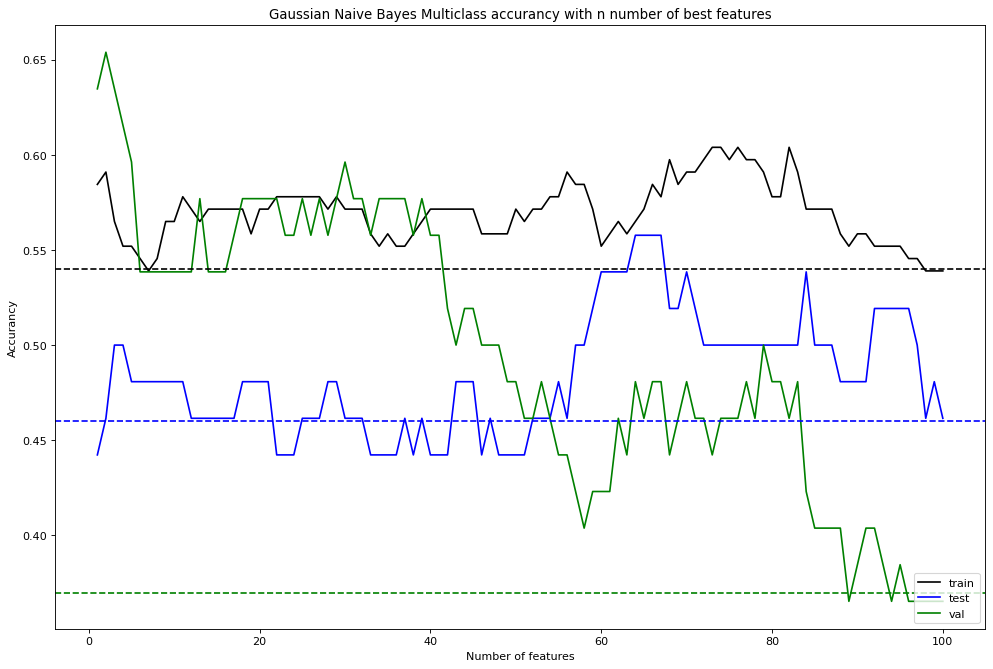

In [410]:
# Define X and y for full dataset
X_npf = npf_train.iloc[:,2:]
y_npf = npf_train["class4"]
X_npf = normalize_0to1(X_npf)

len_cols = len(X_train_norm.columns)+1

acc_train = []
acc_test = []
acc_val = []

for i in range(1, (len_cols)):
    
    # Train filter with full dataset. Find i number of best col names.
    bestFeatureCols = find_n_best_feature(X_npf, y_npf, i)
    
    # Filter train, val and test set with bestFeaturesFilter
    X_train_i = X_train[bestFeatureCols]
    X_val_i = X_val[bestFeatureCols]
    X_test_i = X_test[bestFeatureCols]
    
    #X_val_i = bestFeaturesFilter.fit_transform(X_val_norm, y_val)
    #X_test_i = bestFeaturesFilter.fit_transform(X_test_norm, y_test)
    
    
    # Train Gaussian Naive Bayes model
    model = GaussianNB()
    model.fit(X_train_i, y_train)
    
    # Save accurancy to list
    acc_train.append(accuracy_score(y_train, model.predict(X_train_i)))
    acc_test.append(accuracy_score(y_test, model.predict(X_test_i)))
    acc_val.append(accuracy_score(y_val, model.predict(X_val_i)))

# Plot the results
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
x = range(1, len_cols)
plt.plot(x, acc_train, color="black")
plt.plot(x, acc_test, color="blue")
plt.plot(x, acc_val, color="green")
plt.axhline(y=0.54, color='black', linestyle='--')
plt.axhline(y=0.46, color='blue', linestyle='--')
plt.axhline(y=0.37, color='green', linestyle='--')
plt.title('Gaussian Naive Bayes Multiclass accurancy with n number of best features')
plt.xlabel('Number of features')
plt.ylabel('Accurancy')
plt.legend(["train", "test", "val"], loc ="lower right") 
plt.show()